In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from utide import solve

# latitude of tide gauge (needed for tidal analysis)
lat = 56.550

### Data Source

* Raw, hourly sea level data for Nain (Station #1430) downloaded from [DFO](https://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/inventory-inventaire/sd-ds-eng.asp?no=1430&user=isdm-gdsi&region=ATL). This dataset goes from 1963-2021.

In [13]:
# read data into `pandas.DataFrame`
df = pd.read_csv(
    'DFO1430_full.csv',                         # Data downloaded from DFO 1430
    header=7,                                   # Seven line header
    parse_dates=[['Obs_date', 'Obs_time']],     # Identify date & time columns
)

# convert columns with date/time information to datetime object
df["time"] = pd.to_datetime(df["Obs_date_Obs_time"])

# remove the columns with date/time information
df = df.drop(["Obs_date_Obs_time"], axis=1)

# use the datetime object as index
df = df.set_index("time")
df

,SLEV(metres)
time,
1963-10-17 05:00:00,0.53
1963-10-17 06:00:00,0.65
1963-10-17 07:00:00,0.97
1963-10-17 08:00:00,1.38
1963-10-17 09:00:00,1.87
...,...
2021-12-31 00:00:00,0.99
2021-12-31 01:00:00,0.71
2021-12-31 02:00:00,0.59


In [18]:
# create a new index from the date range specified
# use hourly frequency to match the hourly gage data

index = pd.date_range('1963-10-17 ', '2021-12-31', freq='H')

# reassign new index to df
df=df.reindex(index=index)

# display the first 10 rows of the df
df.head(10)

,SLEV(metres)
1963-10-17 00:00:00,NaN
1963-10-17 01:00:00,NaN
1963-10-17 02:00:00,NaN
1963-10-17 03:00:00,NaN
1963-10-17 04:00:00,NaN
1963-10-17 05:00:00,0.53
1963-10-17 06:00:00,0.65
1963-10-17 07:00:00,0.97
1963-10-17 08:00:00,1.38
1963-10-17 09:00:00,1.87


### Figure: Raw Time Series

[Text(0.5, 1.0, 'Raw Hourly Sea Level Record for Nain (Source: DFO)'),
 Text(0, 0.5, 'Sea Level [m]')]

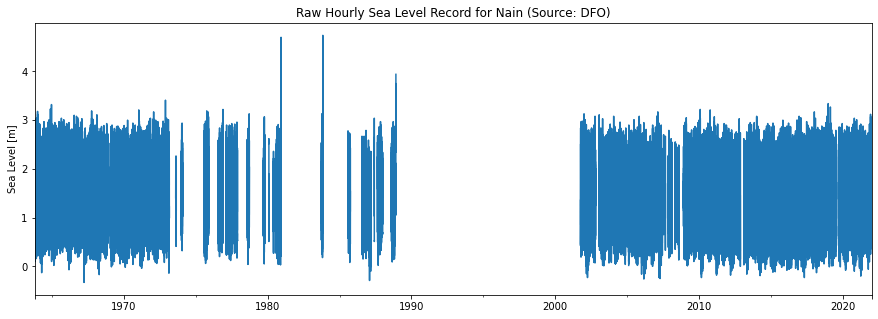

In [4]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot "height" column against index (which is the a datetime object)
df["SLEV(metres)"].plot(
    ax=ax          # use axis `ax` created above
)

# title and axis label
ax.set(
    title="Raw Hourly Sea Level Record for Nain (Source: DFO)",
    ylabel="Sea Level [m]"
)

## Tidal Analysis

From [UTide GitHub page](https://github.com/wesleybowman/UTide):

```
coef = solve(time, time_series_u, time_series_v,
             lat=30,
             nodal=False,
             trend=False,
             method='ols',
             conf_int='linear',
             Rayleigh_min=0.95,)
```

In [5]:
def tidal_analysis(ser, latitude):
    """ Wrapper function for tidal analsyis with UTide.

    Parameters
    ----------
    ser : `pandas.Series`
        Input sea level time seriesl.
    lat : float
        Latitude of tide gauge.

    Returns
    -------
    df_out : `pandas.DataFrame
        Tidal amplitudes and phases with confidence interval. Each row is for
        one tidal constituent.
    
    """
        
    # make a time variable in floating point days since a given epoch
    time = mdates.date2num(ser.index.to_pydatetime())
    
    # make sure there are some sea level values
    if not ser.isnull().all():
    
        # use UTide to run tidal analysis
        coef = solve(
            time, ser.values,   # input variables: time and sea level as numpy arrays
            lat=latitude,       # latitude of tide gauge
            nodal=False,       
            trend=False,
            method="ols",
            conf_int="linear",
            Rayleigh_min=0.95,
            verbose=False       # no messages
        )

        # combine amplitudes and phases and their confidence interval in `numpy.Array`
        data = np.c_[coef["A"], coef["A_ci"], coef["g"], coef["g_ci"]]
        
        # index
        index = coef["name"]
    
    # if `ser` only contains NaNs, return empty `pandas.DataFrame`
    else:
        data = None
        index = None
        
    
    # create output `pandas.DataFrame
    df_out = pd.DataFrame(
        data=data,
        index=index,
        columns=["A", "A_ci", "g", "g_ci"]
    )
    
    return df_out

### Tidal Analysis

Running the tidal analysis for chunks of the gage record and plotting it binned by month.

In [121]:
result = df["SLEV(metres)"].loc["2010":"2021"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

#### Figure: Monthly M2 Amplitudes 2010-2022

[Text(0.5, 1.0, 'Monthly M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

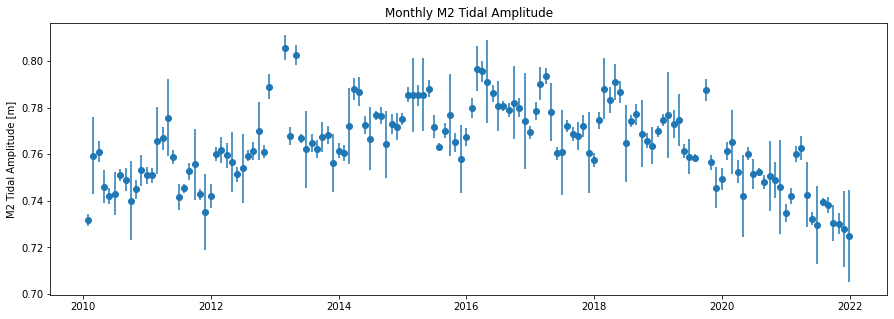

In [122]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Monthly {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)


The same analysis breaks for the longer record. For example, here are the results if we extend the dates:

In [123]:
result = df["SLEV(metres)"].loc["2009":"2021"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

#### Figure: Monthly M2 Amplitudes 2009-2022

[Text(0.5, 1.0, 'Monthly M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

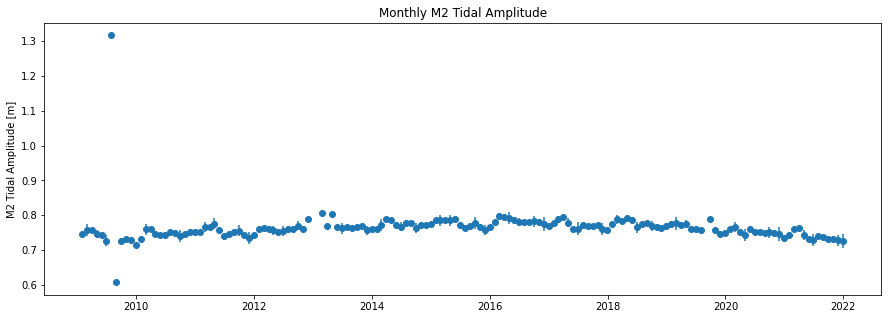

In [124]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Monthly {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
    #ylim=(0,3000)
)

If we compare the tidal analysis to the raw gage height data for the problematic year (2009) it looks like the issue might be related to missing data:

In [125]:
result = df["SLEV(metres)"].loc["2009":"2009"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

#### Figure: Monthly M2 Amplitudes 2009-2010

[Text(0.5, 1.0, 'Monthly M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

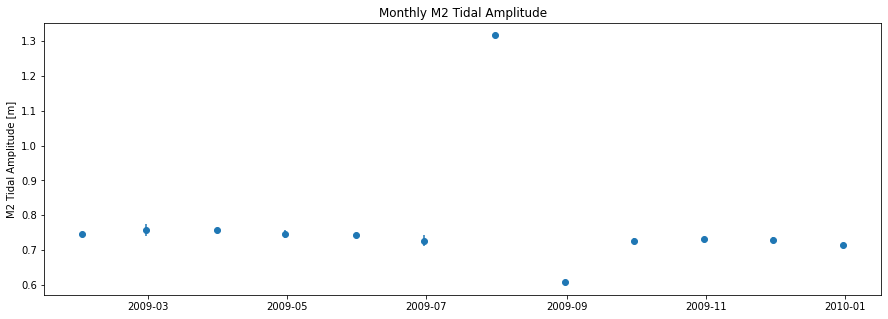

In [126]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Monthly {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

#### Figure: Raw Gage Height Data 2009-2010

[Text(0.5, 1.0, 'Raw Hourly Sea Level Record for Nain (Source: DFO)'),
 Text(0, 0.5, 'Sea Level [m]')]

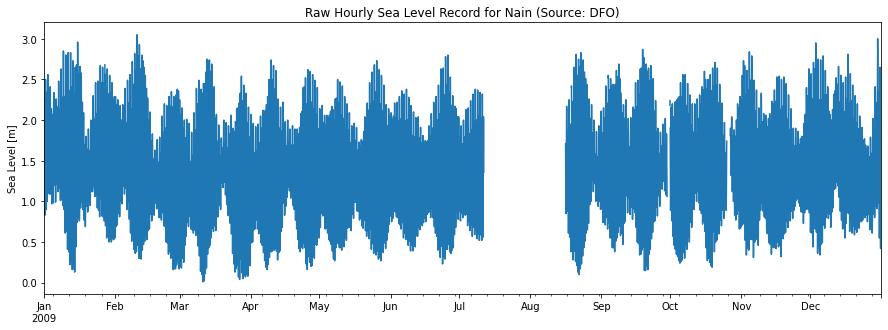

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot "height" column against index (which is the a datetime object)
df["SLEV(metres)"].loc["2009":"2009"].plot(
    ax=ax          # use axis `ax` created above
)

# title and axis label
ax.set(
    title="Raw Hourly Sea Level Record for Nain (Source: DFO)",
    ylabel="Sea Level [m]"
)

And if we compare the raw gage height data for this "bad" year to a "good" year (e.g., 2020) the raw values aren't off by much:

In [128]:
JuneNov_2020 = df["2020-06":"2020-11"]
JuneNov_2009 = df["2009-06":"2009-11"]

#### Figure: Raw Gage Height in 2009 vs.2020

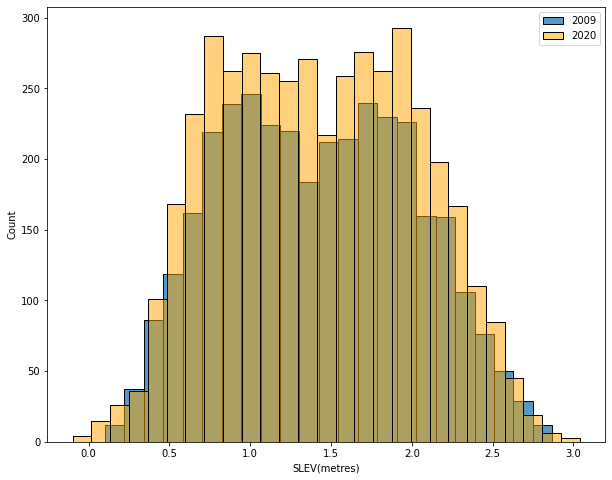

In [129]:
fig, ax = plt.subplots(figsize=(10,8))

sns.histplot(JuneNov_2009['SLEV(metres)'])
sns.histplot(JuneNov_2020['SLEV(metres)'], color='orange', alpha=0.5)

plt.legend(labels=["2009","2020"])
plt.show()

Checking how the missing data are coded in the record:

In [130]:
df["2009-07-11 16:00:00" :"2009-08-16 07:00"]

,SLEV(metres)
2009-07-11 16:00:00,1.36
2009-07-11 17:00:00,NaN
2009-07-11 18:00:00,NaN
2009-07-11 19:00:00,NaN
2009-07-11 20:00:00,NaN
...,...
2009-08-16 03:00:00,NaN
2009-08-16 04:00:00,NaN
2009-08-16 05:00:00,NaN
2009-08-16 06:00:00,NaN


In 2009, the anomalously large amplitude is 1.3 meters - but the tidal analysis estimates **much** larger tidal amplitudes for other parts of the record. For example, if we look at 2007, the values are absolutely nuts:

In [132]:
# pandas magic
result = df["SLEV(metres)"].loc["2007":"2007"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

#### Figure: Monthly M2 Amplitudes 2007-2008

[Text(0.5, 1.0, 'Monthly M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

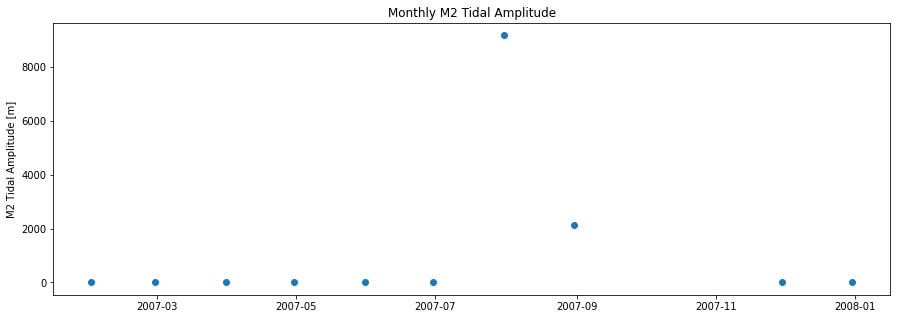

In [133]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Monthly {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

And that isn't reflected in the numbers we see in the raw data for the same time period:

#### Figure: Raw Gage Height Data 2007-2008

[Text(0.5, 1.0, 'Raw Hourly Sea Level Record for Nain (Source: DFO)'),
 Text(0, 0.5, 'Sea Level [m]')]

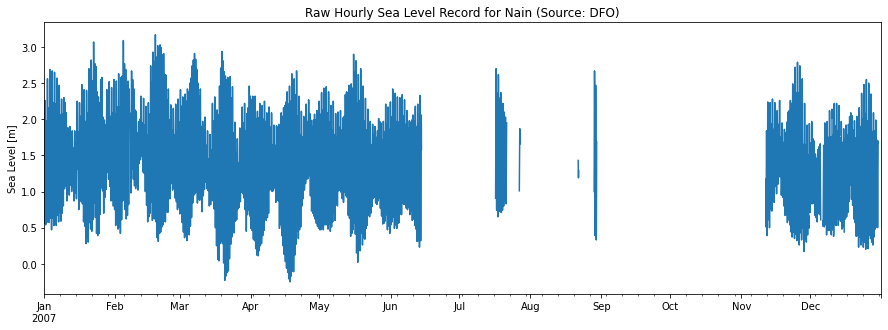

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot "height" column against index (which is the a datetime object)
df["SLEV(metres)"].loc["2007":"2007"].plot(
    ax=ax          # use axis `ax` created above
)

# title and axis label
ax.set(
    title="Raw Hourly Sea Level Record for Nain (Source: DFO)",
    ylabel="Sea Level [m]"
)

### Tidal Analysis for the entire record:

In [142]:
# pandas magic
result = df["SLEV(metres)"].loc["1963":"2021"].groupby(pd.Grouper(freq="Y")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

/Users/dilemmajayne/opt/anaconda3/lib/python3.7/site-packages/utide/confidence.py:243: RuntimeWarning: invalid value encountered in sqrt
  sig1, sig2 = ut_linci(Xu[c], Yu[c], np.sqrt(varXu), np.sqrt(varYu))


[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

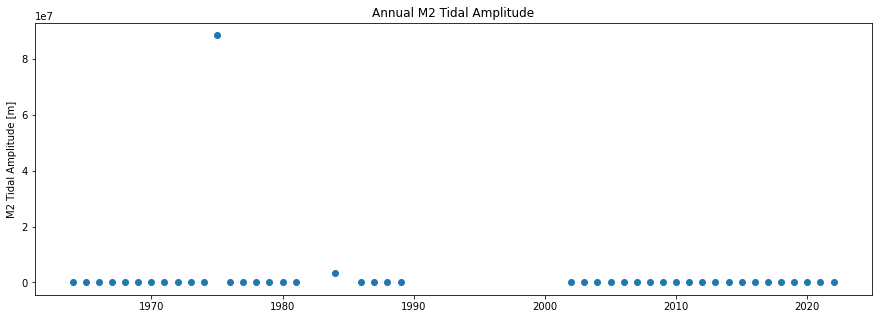

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

### Restricting the visualization to the "reasonable" results range:

[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]'),
 (0.6, 0.9)]

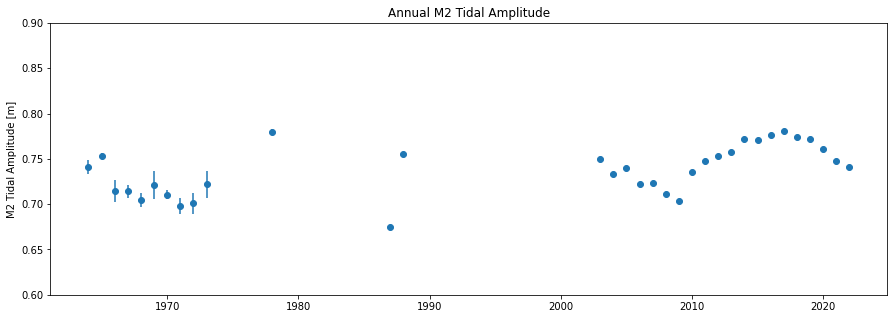

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
    ylim=(0.6,0.9)
)